Looking for images in: ../data/train/images
Looking for masks in: ../data/train/labels
Found 500 files. Loading...
Successfully loaded 500 images and masks.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_15[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_4[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_5[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_6[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_7[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ conv2d_22[0][0] 

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Starting Training...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8465 - loss: 0.2940 - val_accuracy: 0.8890 - val_loss: 0.2029
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8755 - loss: 0.2039 - val_accuracy: 0.8890 - val_loss: 0.2089
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8755 - loss: 0.1893 - val_accuracy: 0.8890 - val_loss: 0.1685
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8755 - loss: 0.1867 - val_accuracy: 0.8890 - val_loss: 0.1537
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8755 - loss: 0.1640 - val_accuracy: 0.8890 - val_loss: 0.1580
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8755 - loss: 0.1513 - val_accuracy: 0.8890 - val_loss: 0.1432
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8755 - loss: 0.1633 - val_accuracy: 0.8890 - val_loss: 0.2254
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8755 - loss: 0.1502 - val_accurac

Model saved at ../saved_models/unet_oil_spill.h5


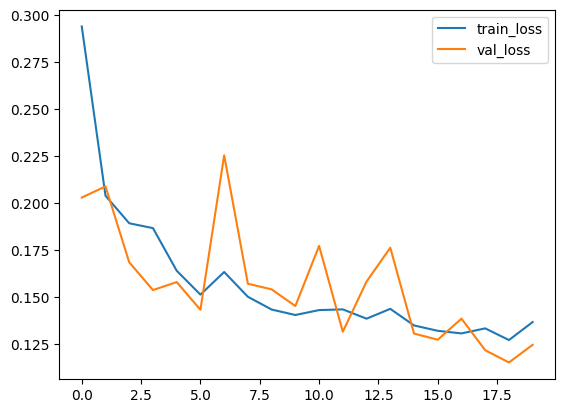

In [2]:
# 1_UNet_Training.ipynb

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# --- CONFIGURATION ---
IMG_HEIGHT = 256
IMG_WIDTH = 256
CHANNELS = 3
DATA_PATH = '../data/train' # Ensure your data is here
MODEL_SAVE_PATH = '../saved_models/unet_oil_spill.h5'

# --- 1. SMART DATA LOADING HELPER ---
def load_data(path):
    """
    Loads images and masks.
    Includes automatic fix for .jpg vs .png extension mismatch.
    """
    images = []
    masks = []
    
    img_dir = os.path.join(path, 'images')
    mask_dir = os.path.join(path, 'labels') 
    
    print(f"Looking for images in: {img_dir}")
    print(f"Looking for masks in: {mask_dir}")

    if not os.path.exists(img_dir):
        raise FileNotFoundError(f"ERROR: Image folder not found at {img_dir}")
    
    if not os.path.exists(mask_dir):
        # Fallback for different folder naming conventions
        mask_dir_alt = os.path.join(path, 'masks')
        if os.path.exists(mask_dir_alt):
            print(f"Found 'masks' folder instead of 'labels'. Using that.")
            mask_dir = mask_dir_alt
        else:
            raise FileNotFoundError(f"ERROR: Mask folder not found at {mask_dir}")

    files = os.listdir(img_dir)[:500] 
    print(f"Found {len(files)} files. Loading...")

    for file_name in files:
        # Load Image
        img_path = os.path.join(img_dir, file_name)
        img = cv2.imread(img_path)
        
        if img is None:
            continue 
        
        # Find Mask
        mask_path = os.path.join(mask_dir, file_name)
        
        # Handle PNG/JPG mismatch
        if not os.path.exists(mask_path):
            file_name_png = os.path.splitext(file_name)[0] + ".png"
            mask_path = os.path.join(mask_dir, file_name_png)
            
        mask = cv2.imread(mask_path, 0) 
        
        if mask is None:
            print(f"Skipping {file_name} - No mask found.")
            continue

        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        
        images.append(img)
        masks.append(mask)
        
    images = np.array(images) / 255.0
    masks = np.array(masks) / 255.0
    masks = np.expand_dims(masks, axis=-1)
    
    return images, masks

# Load Data
try:
    X, y = load_data(DATA_PATH)
    print(f"Successfully loaded {len(X)} images and masks.")
except Exception as e:
    print(e)
    exit() 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. BUILD U-NET MODEL ---
def simple_unet_model(n_classes=1, img_height=256, img_width=256, img_channels=3):
    inputs = Input((img_height, img_width, img_channels))
    
    # Contraction
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    
    # Expansion
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3]) 
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2]) 
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1]) 
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = simple_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# --- 3. TRAINING ---
print("Starting Training...")
history = model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_val, y_val))

# --- 4. SAVE MODEL ---
model.save(MODEL_SAVE_PATH)
print(f"Model saved at {MODEL_SAVE_PATH}")

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()